In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Loading data

In [3]:
df = pd.read_csv("churn_rate_prediction.csv")

In [3]:
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [5]:
df.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [6]:
df.duplicated().any()

False

Có 3 feature có missing value: region_category, preferred_offer_types, points_in_wallet và không có dữ liệu trùng. Trong đó, cột 'region_category' có giá trị null cao nhất trong tập dữ liệu trong khi cột 'preferred_offer_types' có ít nhất.

In [7]:
df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


### Data exploratory

In [4]:
# Get categorical columns and numerical columns
categorical_cols = [feature for feature in df.columns if df[feature].dtype == "O"]
numerical_cols = [feature for feature in df.columns if df[feature].dtype != "O"]
print("Categorical_cols:", categorical_cols)
print("Numerical_cols: ", numerical_cols)

Categorical_cols: ['customer_id', 'Name', 'gender', 'security_no', 'region_category', 'membership_category', 'joining_date', 'joined_through_referral', 'referral_id', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'last_visit_time', 'avg_frequency_login_days', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback']
Numerical_cols:  ['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'points_in_wallet', 'churn_risk_score']


<Axes: xlabel='churn_risk_score', ylabel='count'>

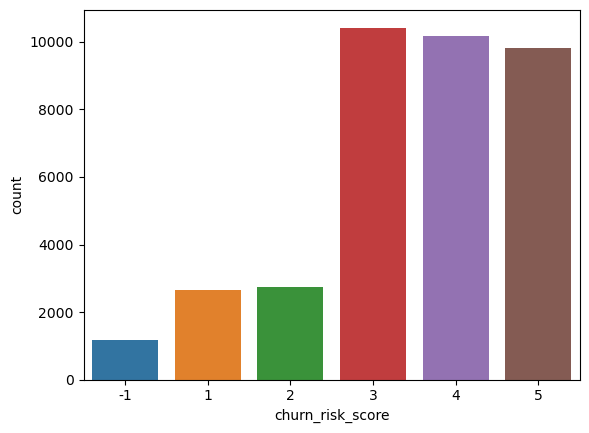

In [9]:
# check target feature distribution
sns.countplot(x='churn_risk_score', data=df)

Trong cột label có chứa giá trị -1, giá trị này chưa đúng và cần chuyển thành 1

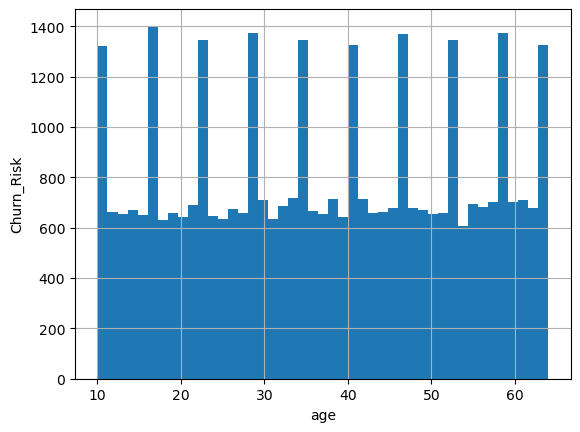

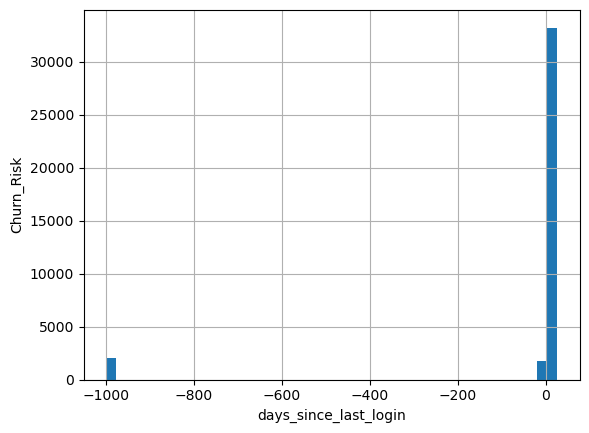

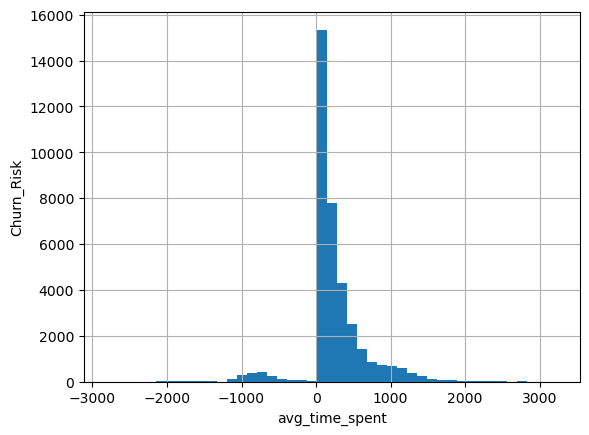

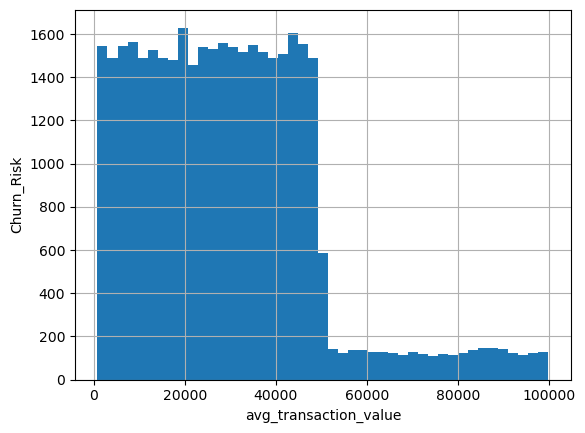

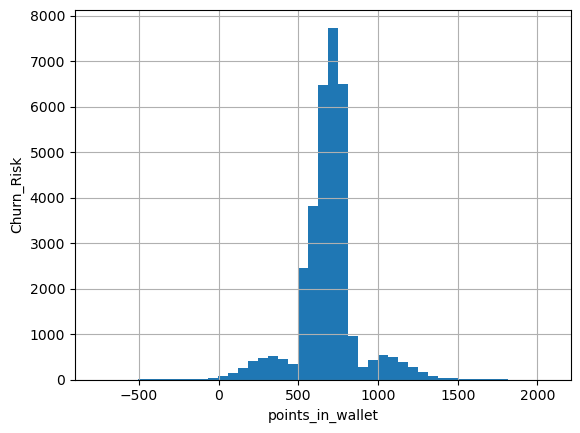

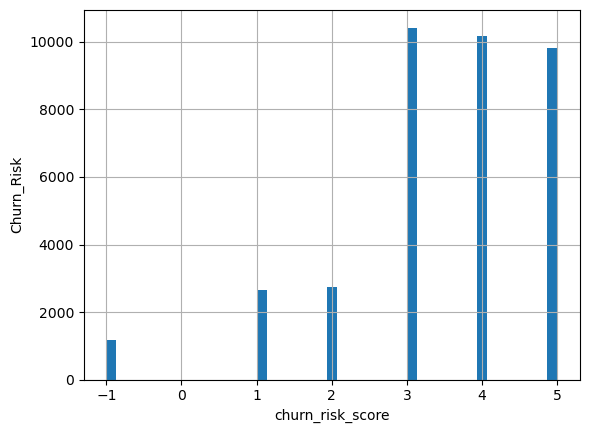

In [10]:
for feature in numerical_cols:
  data = df.copy()
  data[feature].hist(bins=45)
  plt.xlabel(feature)
  plt.ylabel('Churn_Risk')
  plt.show()

Từ các biểu đồ, có thể thấy một số cột bị lệch (skewed). Ngoài ra, biến mục tiêu (churn_risk_score) có chứa các outlier.

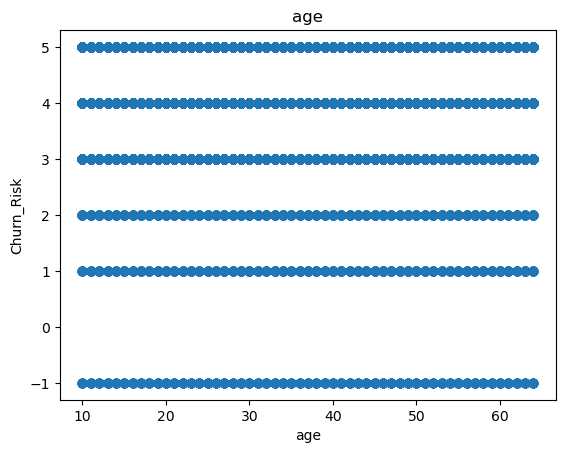

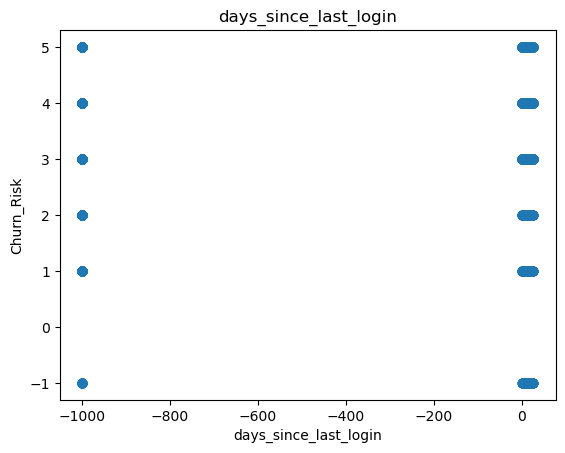

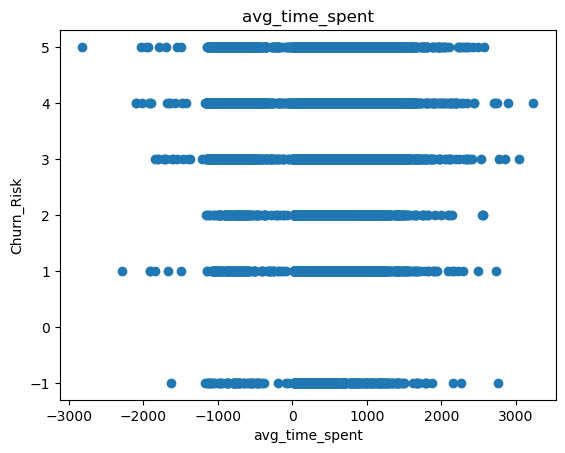

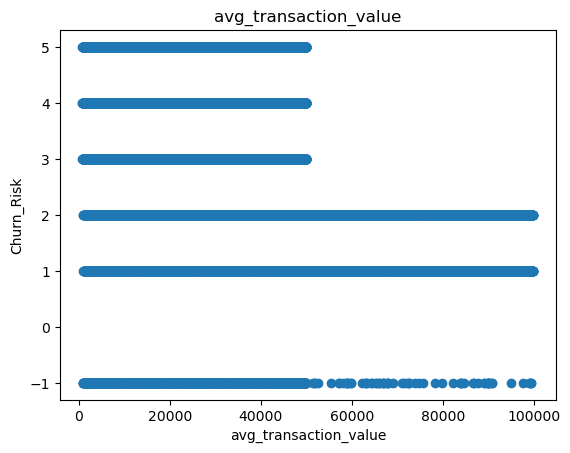

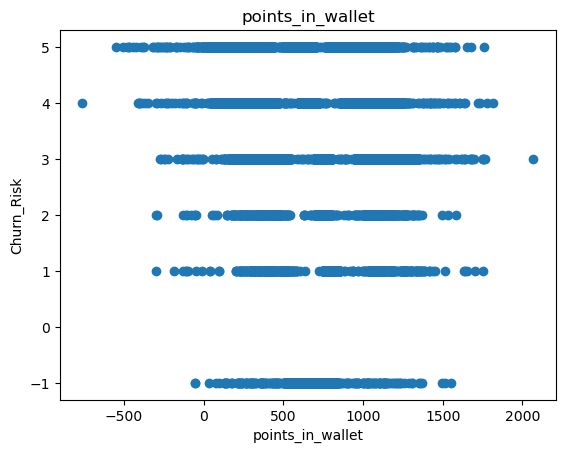

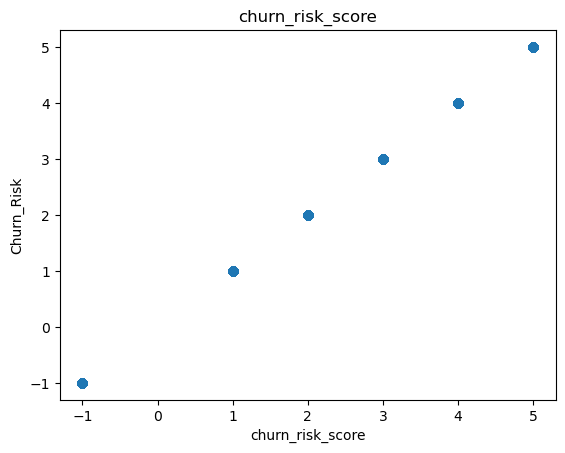

In [11]:
#visualizing outliers with scatter plot
for feature in numerical_cols:
    data_copy = df.copy()
    plt.scatter(data_copy[feature],data_copy['churn_risk_score'])
    plt.xlabel(feature)
    plt.ylabel('Churn_Risk')
    plt.title(feature)
    plt.show()


Từ biểu đồ phân tán, hầu hết các cột đều chứa các giá trị ngoại lệ, ngay cả biến mục tiêu có churn_risk_score = -1

<Axes: >

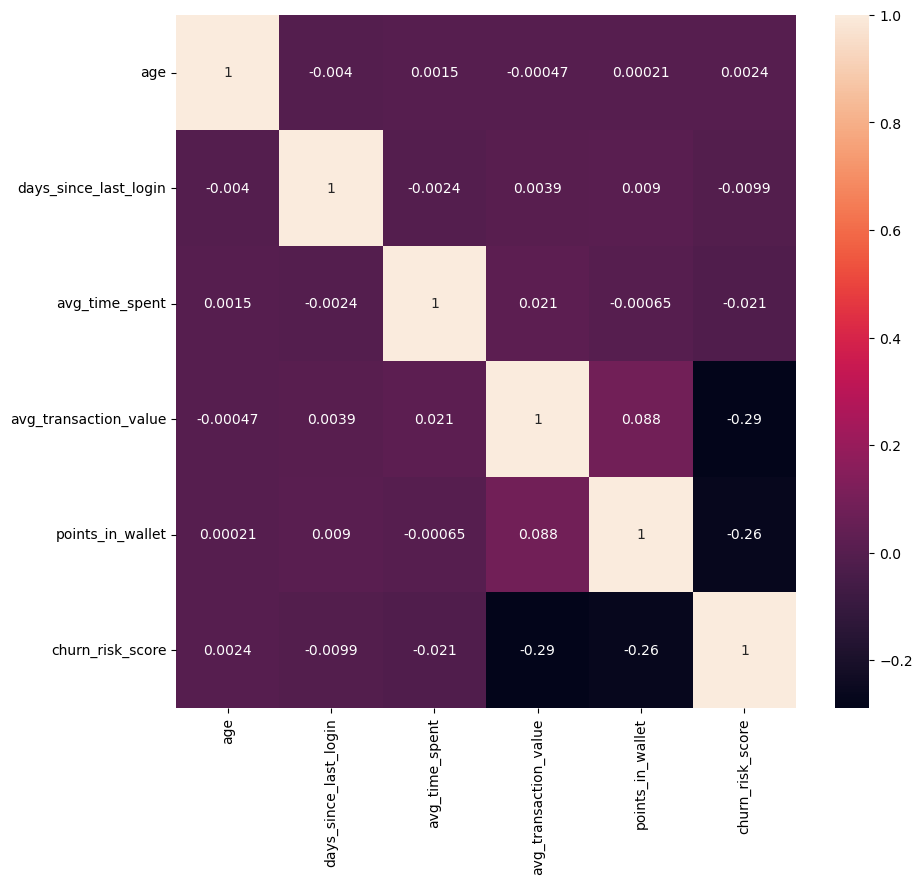

In [12]:
plt.figure(figsize=(10,9))
sns.heatmap(df[numerical_cols].corr(),annot=True)

## Data processing

In [5]:
# setting target wrong value -1 to 1 assuming sign issue, 
df['churn_risk_score'] = df['churn_risk_score'].apply(lambda x:0 if x == -1  else x - 1)
df['churn_risk_score'].unique()

array([1, 0, 4, 2, 3], dtype=int64)

<Axes: xlabel='churn_risk_score'>

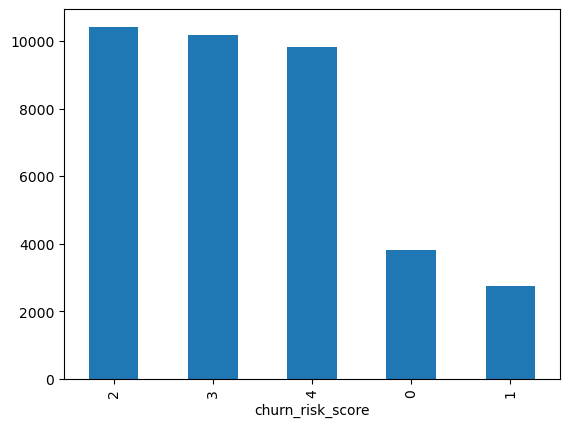

In [6]:
df['churn_risk_score'].value_counts().plot.bar()

#### gender

In [7]:
df['gender'].value_counts()

gender
F          18490
M          18443
Unknown       59
Name: count, dtype: int64

Vì trong cột gender có các giá trị 'Unknown' mà số lượng rất ít, không ảnh hưởng nhiều đến dữ liệu nên loại bỏ những giá trị này

In [8]:
# Drop Unknown in gender column
df = df.drop(df[(df['gender'] == 'Unknown')].index)

#### region_category

In [9]:
df['region_category'].value_counts()

region_category
Town       14099
City       12721
Village     4693
Name: count, dtype: int64

In [10]:
df.groupby('region_category')['avg_transaction_value'].mean()

region_category
City       29116.413261
Town       29106.995445
Village    30462.852391
Name: avg_transaction_value, dtype: float64

In [11]:
correlation = np.corrcoef(df['region_category'].astype('category').cat.codes, df['avg_transaction_value'])[0, 1]
print('Correlation coefficient:', correlation)

Correlation coefficient: 0.015799126912743575


Ta thấy giữa feature region_category có tương quan với feature 'avg_transaction_value' nên dựa vào feature avg_transaction_value để fill NA cho feature region_category bằng cách sử dụng model Decision Tree.

In [12]:
from sklearn.tree import DecisionTreeClassifier

data_complete = df.dropna(subset=['region_category', 'avg_transaction_value'])
data_missing = df[df['region_category'].isna()]

# Tạo X và y từ dữ liệu có đầy đủ
X = data_complete['avg_transaction_value'].values.reshape(-1, 1)
y = data_complete['region_category']

model = DecisionTreeClassifier()
model.fit(X, y)

# Dự đoán giá trị bị mất trong categorical feature
X_missing = data_missing['avg_transaction_value'].values.reshape(-1, 1)
predicted_values = model.predict(X_missing)

# Điền các giá trị dự đoán vào dữ liệu bị mất
data_missing['region_category'] = predicted_values

# Kết hợp dữ liệu đã điền giá trị vào dữ liệu gốc
data_filled = pd.concat([data_complete, data_missing])
df = data_filled.combine_first(df)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15068\1875850999.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_missing['region_category'] = predicted_values


<Axes: xlabel='region_category'>

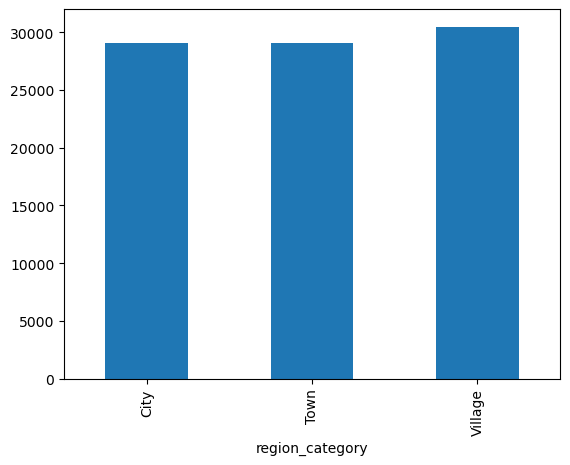

In [13]:
#data_combined['region_category'].value_counts()
df.groupby('region_category')['avg_transaction_value'].mean().plot.bar()

#### preferred_offer_types

In [14]:
df['preferred_offer_types'].isna().sum()

287

Feature 'preferred_offer_types' có chứa missing value nên thay thế bằng giá trị mode

In [15]:
df['preferred_offer_types'] = df['preferred_offer_types'].fillna(df['preferred_offer_types'].mode()[0])
df['preferred_offer_types'].unique()

array(['Gift Vouchers/Coupons', 'Credit/Debit Card Offers',
       'Without Offers'], dtype=object)

#### joined_through_referral & medium_of_operation

In [16]:
df['joined_through_referral'].unique()

array(['No', '?', 'Yes'], dtype=object)

Feature 'joined_through_referral' có chứa giá trị '?', giá trị này không có ý nghĩa nên thay thế bằng 'No'

In [17]:
df['joined_through_referral'] = df['joined_through_referral'].apply(lambda x:'No' if x == '?' else x)
df['joined_through_referral'].unique()

array(['No', 'Yes'], dtype=object)

In [18]:
df['medium_of_operation'].unique()

array(['?', 'Desktop', 'Smartphone', 'Both'], dtype=object)

Feature 'medium_of_operation' có chứa giá trị '?', giá trị này không có ý nghĩa nên thay thế bằng 'Desktop'

In [19]:
df['medium_of_operation'] = df['medium_of_operation'].apply(lambda x:'Desktop' if x == '?' else x)
df['medium_of_operation'].unique()

array(['Desktop', 'Smartphone', 'Both'], dtype=object)

#### days_since_last_login & avg_time_spent

In [20]:
# check target feature distribution
(df['days_since_last_login'] < 0).any()

True

In [21]:
(df['avg_time_spent'] < 0).any()

True

Feature 'days_since_last_login' và 'avg_time_spent' chứa các giá trị âm nên thay giá trị âm bằng 0

In [22]:
# Replace negative value in 'days_since_last_login'
df.loc[df['days_since_last_login'] < 0, 'days_since_last_login'] = 0

In [23]:
# Replace negative value in 'avg_time_spent' 
df.loc[df['avg_time_spent'] < 0, 'avg_time_spent'] = 0

#### churn_risk_score

In [24]:
df['churn_risk_score'].value_counts()

churn_risk_score
2    10404
3    10175
4     9808
0     3808
1     2738
Name: count, dtype: int64

#### avg_frequency_login_days

In [25]:
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].apply(lambda x:0 if x == 'Error' else x)
df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'])
df.loc[df['avg_frequency_login_days'] < 0, 'avg_frequency_login_days'] = 0
df['avg_frequency_login_days'].describe()

count    36933.000000
mean        14.658198
std          9.479883
min          0.000000
25%          7.000000
50%         14.000000
75%         22.000000
max         73.061995
Name: avg_frequency_login_days, dtype: float64

#### points_in_wallet

In [26]:
df['points_in_wallet'].isna().sum()

3434

Feature 'points_in_wallet' có chứa missing value, và feature này có tương quan với feature 'churn_risk_score' là -0.26 (theo biểu đồ heatmap) nên dựa vào sự tương quan đó để fill NA cho feature 'point_in_wallet' bằng cách mapping giá trị trung bình point_in_wallet tương ứng với mỗi label.

In [27]:
mean_by_churn_risk_score = df.groupby('churn_risk_score')['points_in_wallet'].mean()
mean_by_churn_risk_score

churn_risk_score
0    762.668030
1    745.082491
2    749.284419
3    661.346662
4    601.211935
Name: points_in_wallet, dtype: float64

<Axes: xlabel='churn_risk_score'>

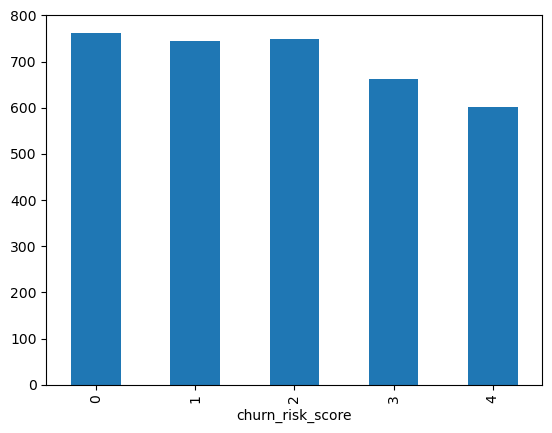

In [28]:
df.groupby('churn_risk_score')['points_in_wallet'].mean().plot.bar()

In [29]:
df['points_in_wallet'] = df['points_in_wallet'].fillna(df['churn_risk_score'].map(mean_by_churn_risk_score))

####  Non-useful Features
Khi xem xét các feature, ta nhận thấy rằng có các feature không cần thiết, nên loại bỏ các feature này khỏi data

In [30]:
# remove non-useful features
colsToRemove = ['customer_id', 'Name', 'security_no', 'referral_id', 'last_visit_time']
df.drop(colsToRemove, inplace=True, axis=1)
df.head()

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,Platinum Membership,2017-08-17,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,17,300.63,53005.25,17.0,781.75000,Yes,Yes,No,Not Applicable,Products always in Stock,1
1,32,F,City,Premium Membership,2017-08-28,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.34,12838.38,10.0,762.66803,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,Town,No Membership,2016-11-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.16,21027.00,22.0,500.69000,No,Yes,Yes,Solved in Follow-up,Poor Website,4
3,37,M,City,No Membership,2016-10-29,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.27,25239.56,6.0,567.66000,No,Yes,Yes,Unsolved,Poor Website,4
4,31,F,City,No Membership,2017-09-12,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.13,24483.66,16.0,663.06000,No,Yes,Yes,Solved,Poor Website,4


#### joining_date
Đây là time series feature, nên tạo một biến mới tính số ngày tham gia của thành viên đó và xóa feature 'joining_date' ban đầu

In [31]:
# Change the time series data
df['joining_date'] = pd.to_datetime(df['joining_date'])
df['days_since_joined'] = df['joining_date'].apply(lambda x:(pd.Timestamp('today') - x).days)
df.drop(['joining_date'], inplace=True, axis=1)
df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,days_since_joined
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,17,300.63,53005.25,17.0,781.75000,Yes,Yes,No,Not Applicable,Products always in Stock,1,2496
1,32,F,City,Premium Membership,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.34,12838.38,10.0,762.66803,Yes,No,Yes,Solved,Quality Customer Care,0,2485
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.16,21027.00,22.0,500.69000,No,Yes,Yes,Solved in Follow-up,Poor Website,4,2775
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.27,25239.56,6.0,567.66000,No,Yes,Yes,Unsolved,Poor Website,4,2788
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.13,24483.66,16.0,663.06000,No,Yes,Yes,Solved,Poor Website,4,2470


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36933 entries, 0 to 36991
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36933 non-null  int64  
 1   gender                        36933 non-null  object 
 2   region_category               36933 non-null  object 
 3   membership_category           36933 non-null  object 
 4   joined_through_referral       36933 non-null  object 
 5   preferred_offer_types         36933 non-null  object 
 6   medium_of_operation           36933 non-null  object 
 7   internet_option               36933 non-null  object 
 8   days_since_last_login         36933 non-null  int64  
 9   avg_time_spent                36933 non-null  float64
 10  avg_transaction_value         36933 non-null  float64
 11  avg_frequency_login_days      36933 non-null  float64
 12  points_in_wallet              36933 non-null  float64
 13  used_s

In [32]:
categorical_cols_new = [feature for feature in df.columns if df[feature].dtype == "O"]
categorical_cols_new

['gender',
 'region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

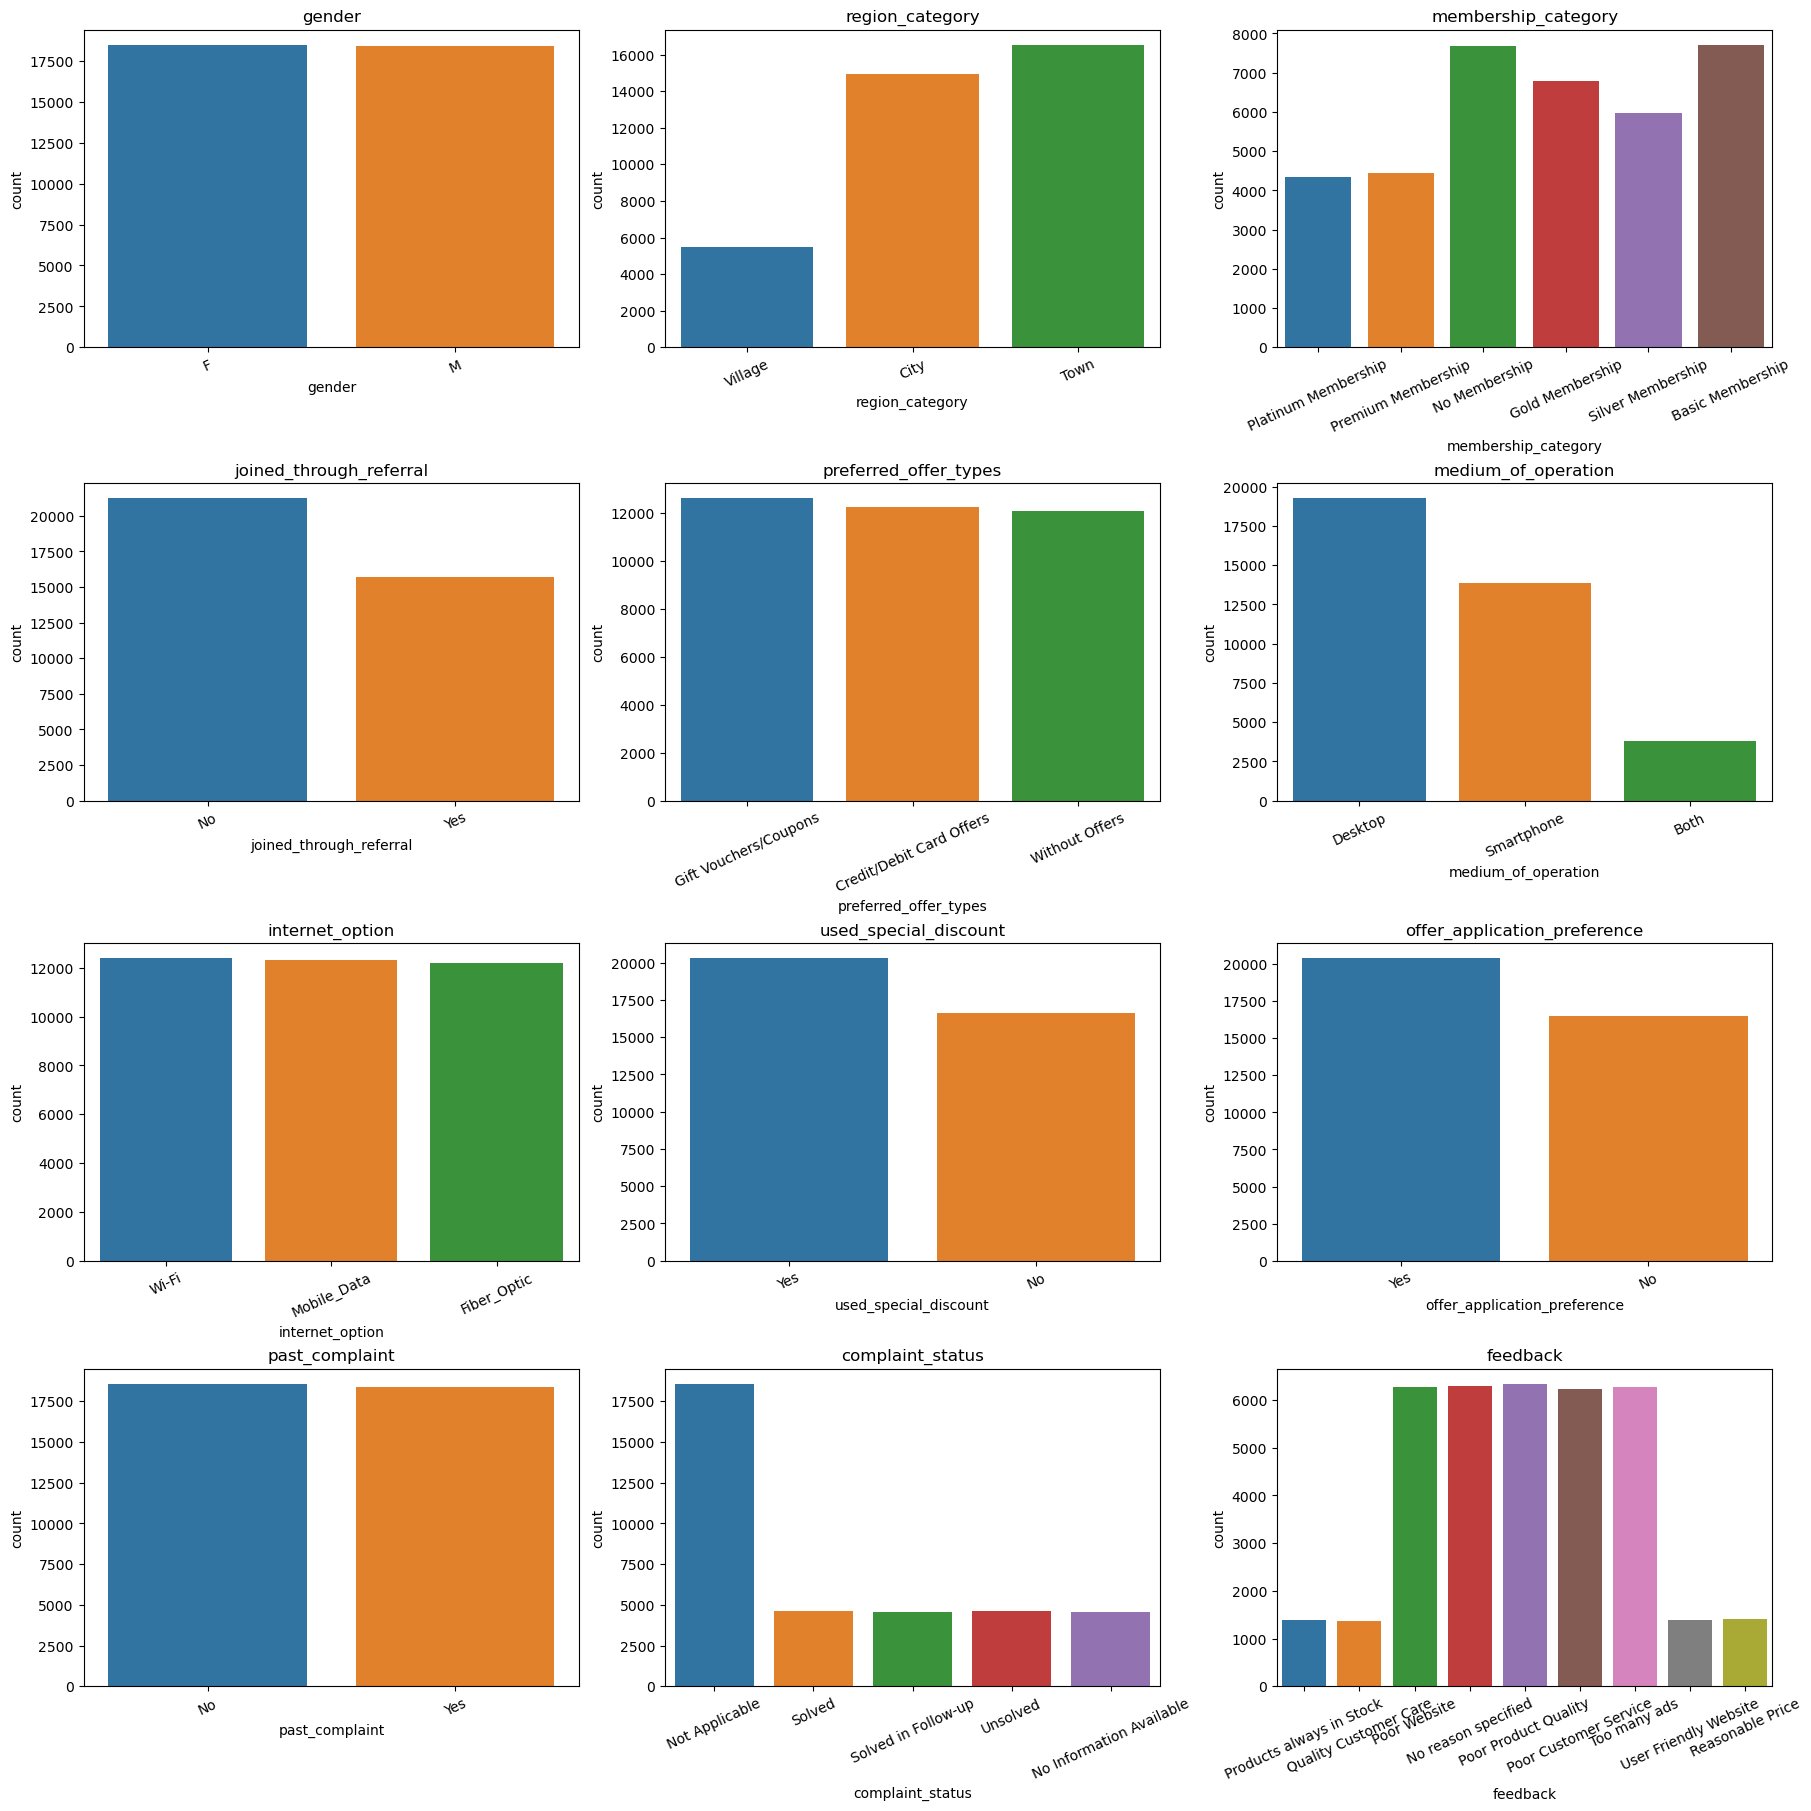

In [33]:
fig, axes = plt.subplots(4, 3, figsize=(18, 18), constrained_layout=True)
for col, ax in zip(categorical_cols_new, axes.flat):
    sns.countplot(data = df, x = col, ax = ax)
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(col)

for ax in axes.flat[12:]: 
    ax.set_axis_off()

#### Từ biểu đồ ta thấy:
+ Với gender, giới tính nam và nữ đề phân bố đều
+ Hầu hết khách hàng đến từ citis và towns
+ Hầu hết khách hàng là basic membership hoặc no membership, rất ít khách hàng là preminum hay platinum
+ Preferred offer types phân bố khá đồng đều
+ Hầu hết khách hàng dùng Desktop hoặc Smartphone làm phương tiện hoạt động
+ Internet option phân bố khá đồng đều
+ Hầu hết các phàn nàn của khách hàng là về chất lượng sản phẩm kém, quảng cáo, trang web kém và dịch vụ khách hàng kém


<Axes: xlabel='churn_risk_score', ylabel='count'>

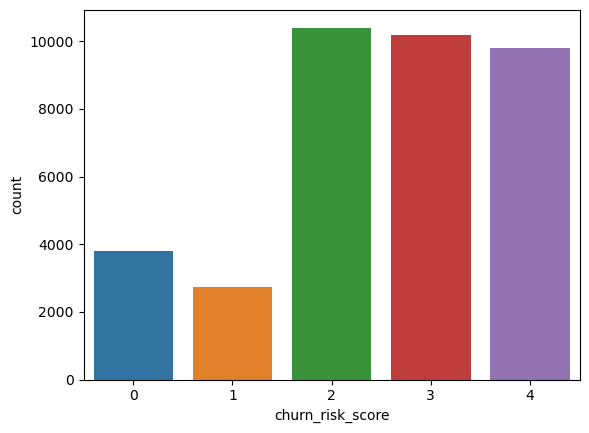

In [43]:
sns.countplot(x='churn_risk_score', data=df)

Các giá trị trong feature churn risk score lệch về 2,3,4

In [34]:
numerical_cols_new = [feature for feature in df.columns if df[feature].dtype != "O"]
numerical_cols_new 

['age',
 'days_since_last_login',
 'avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'churn_risk_score',
 'days_since_joined']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8504\366877531.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x= col, ax = ax, shade = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8504\366877531.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x= col, ax = ax, shade = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8504\366877531.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x= col, ax = ax, shade = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8504\366877531.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become

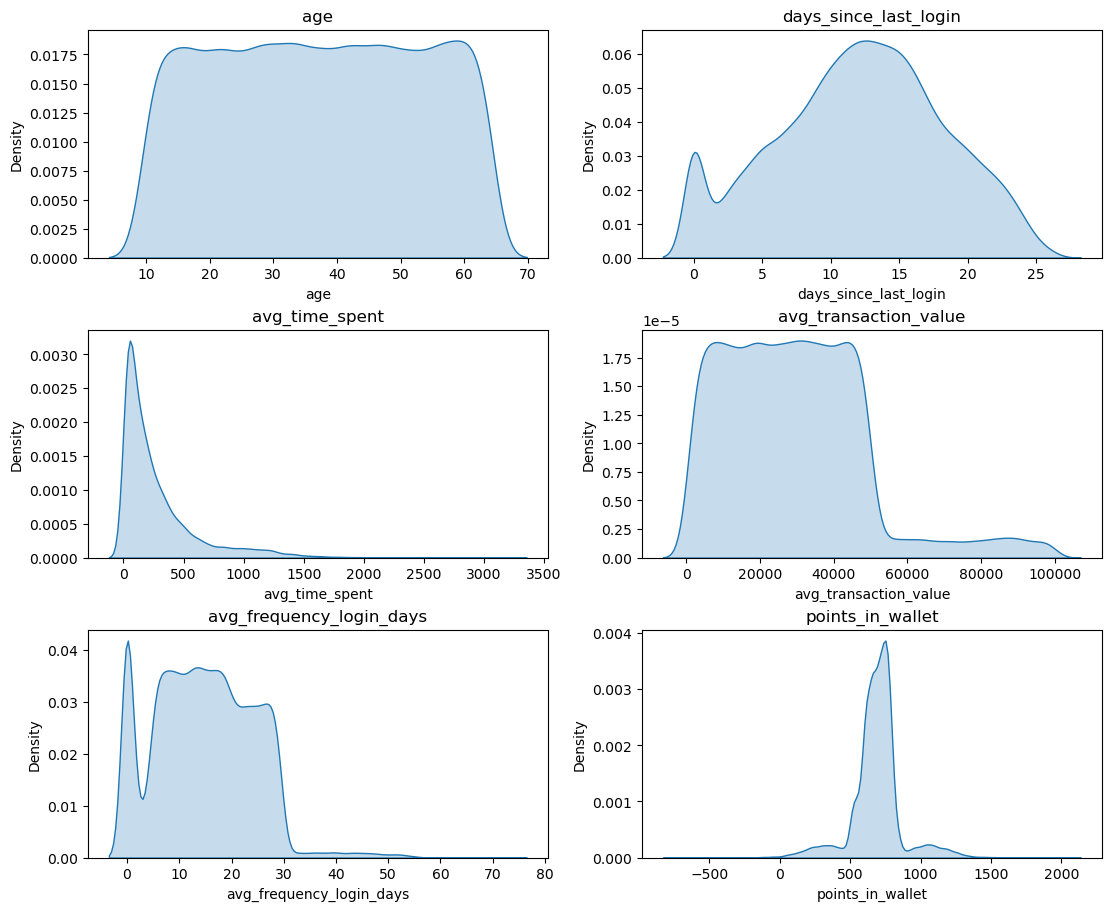

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(11, 9), constrained_layout=True)

for col, ax in zip(numerical_cols_new, axes.flat):
    sns.kdeplot(data = df, x= col, ax = ax, shade = True)
    ax.set_title(col)

#### Từ đồ thị, ta thấy:
+ Feature age phân bố đồng đều
+ Các feature còn lại lệch về một phía

### Label encoding
Như vậy, các vấn đề missing value, error value, kiểu dữ liệu... đã được xử lý, tiếp tục tiến hành label các feature dạng category

In [35]:
# Label encoding on categorical features
def label_feature(data, col):
    feat = data[col].unique()
    feat_idx = [x for x in range(len(feat))]

    data[col].replace(feat, feat_idx, inplace=True)

# Assuming categorical_cols_new is a list of column names
for col in categorical_cols_new:
    label_feature(df, col)

df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,days_since_joined
0,18,0,0,0,0,0,0,0,17,300.63,53005.25,17.0,781.75000,0,0,0,0,0,1,2496
1,32,0,1,1,0,0,0,1,16,306.34,12838.38,10.0,762.66803,0,1,1,1,1,0,2485
2,44,0,2,2,1,0,0,0,14,516.16,21027.00,22.0,500.69000,1,0,1,2,2,4,2775
3,37,1,1,2,1,0,0,1,11,53.27,25239.56,6.0,567.66000,1,0,1,3,2,4,2788
4,31,0,1,2,0,1,1,1,20,113.13,24483.66,16.0,663.06000,1,0,1,1,2,4,2470


In [36]:
def prepare_X_y(df):
   
    feature_names = df.columns.tolist()
    feature_names.remove("churn_risk_score")

    X = df[feature_names]
    y = df.churn_risk_score
   
    return X, y

X, y = prepare_X_y(df.copy())

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Build model

### Decision tree

In [39]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

pred = model.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       820
           1       0.75      0.75      0.75       562
           2       0.90      0.89      0.90      2073
           3       0.69      0.69      0.69      2010
           4       0.74      0.74      0.74      1922

    accuracy                           0.75      7387
   macro avg       0.73      0.73      0.73      7387
weighted avg       0.75      0.75      0.75      7387



In [40]:
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

clf = DecisionTreeClassifier()
pipe = Pipeline(steps=[("tree", clf)]) #Build a pipeline with a scaler and a model

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'tree__criterion': ["gini", "entropy", "log_loss"]
    }

search = GridSearchCV(pipe, param_grid, scoring="f1_micro", n_jobs=2)
search.fit(x_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

predicted_label = search.predict(x_test)
print(classification_report(y_test, predicted_label))

Best parameter (CV score=0.761):
{'tree__criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       820
           1       0.77      0.78      0.77       562
           2       0.91      0.89      0.90      2073
           3       0.69      0.70      0.70      2010
           4       0.75      0.75      0.75      1922

    accuracy                           0.76      7387
   macro avg       0.74      0.75      0.74      7387
weighted avg       0.76      0.76      0.76      7387



In [41]:
def calculate_performance(y_test, y_pred):
    """

    :param y_true: ground truth values
    :param y_pred: predictions
    :return:
    """
    # Todo: return your error value like accuracy, f1score, ...
    print("Precision: ", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall: ", recall_score(y_test, y_pred, average = 'macro'))
    print("F1: ", f1_score(y_test, y_pred, average = 'macro'))

    # Todo: Only choose one of them as your score for the question 7
    main_score = recall_score(y_test, y_pred, average = 'macro')
    return main_score

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
main_score = calculate_performance(y_test, y_pred)
print("Main score: ", main_score)

Precision:  0.7360623451205988
Recall:  0.7374460050703524
F1:  0.7367230349277945
Main score:  0.7374460050703524


### Random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
pipe = Pipeline(steps=[("random_forest", clf)]) #Build a pipeline with a scaler and a model

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'random_forest__criterion': ["gini", "entropy", "log_loss"]
    }

search = GridSearchCV(pipe, param_grid, scoring="f1_micro", n_jobs=2)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

predicted_label = search.predict(x_test)
print(classification_report(y_test, predicted_label))

Best parameter (CV score=0.784):
{'random_forest__criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       820
           1       0.86      0.68      0.76       562
           2       0.89      0.94      0.91      2073
           3       0.71      0.71      0.71      2010
           4       0.76      0.80      0.78      1922

    accuracy                           0.79      7387
   macro avg       0.79      0.76      0.77      7387
weighted avg       0.79      0.79      0.79      7387



In [44]:
main_score = calculate_performance(y_test, predicted_label)
print("Main score: ", main_score)

Precision:  0.7931634116267272
Recall:  0.7564115440725069
F1:  0.7717812819167429
Main score:  0.7564115440725069


### XGBoost

In [46]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

xgb = Pipeline(steps=[('scaler', StandardScaler()),
                         ('model', XGBClassifier())])

xgb.fit(x_train, y_train)

pred = xgb.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69       820
           1       0.81      0.72      0.77       562
           2       0.90      0.94      0.92      2073
           3       0.74      0.68      0.71      2010
           4       0.74      0.85      0.79      1922

    accuracy                           0.79      7387
   macro avg       0.79      0.76      0.77      7387
weighted avg       0.79      0.79      0.79      7387



In [47]:
main_score = calculate_performance(y_test, pred)
print("Main score: ", main_score)

Precision:  0.7894623941684877
Recall:  0.7627947470781866
F1:  0.7734113162129659
Main score:  0.7627947470781866


### Catboost

In [48]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Tạo một pipeline để thực hiện các bước tiền xử lý và mô hình hóa
catb = Pipeline([
    ('scaler', StandardScaler()), # tiền xử lý dữ liệu
    ('classifier', CatBoostClassifier()) # mô hình hóa với CatBoost
])

catb.fit(x_train, y_train)


pred = catb.predict(x_test)
print(classification_report(y_test, pred))

Learning rate set to 0.094041
0:	learn: 1.4289119	total: 409ms	remaining: 6m 48s
1:	learn: 1.2975504	total: 913ms	remaining: 7m 35s
2:	learn: 1.1977533	total: 1.53s	remaining: 8m 29s
3:	learn: 1.1077142	total: 1.83s	remaining: 7m 36s
4:	learn: 1.0401245	total: 2.23s	remaining: 7m 24s
5:	learn: 0.9785947	total: 2.45s	remaining: 6m 45s
6:	learn: 0.9251145	total: 2.72s	remaining: 6m 25s
7:	learn: 0.8758265	total: 2.91s	remaining: 6m
8:	learn: 0.8413090	total: 3.24s	remaining: 5m 57s
9:	learn: 0.8063171	total: 3.44s	remaining: 5m 41s
10:	learn: 0.7761864	total: 3.59s	remaining: 5m 22s
11:	learn: 0.7487298	total: 3.83s	remaining: 5m 15s
12:	learn: 0.7206233	total: 4s	remaining: 5m 3s
13:	learn: 0.6976189	total: 4.18s	remaining: 4m 54s
14:	learn: 0.6747713	total: 4.32s	remaining: 4m 43s
15:	learn: 0.6583166	total: 4.55s	remaining: 4m 40s
16:	learn: 0.6398928	total: 4.78s	remaining: 4m 36s
17:	learn: 0.6259801	total: 4.96s	remaining: 4m 30s
18:	learn: 0.6144405	total: 5.11s	remaining: 4m 23s


In [49]:
main_score = calculate_performance(y_test, pred)
print("Main score: ", main_score)

Precision:  0.7965528045148209
Recall:  0.7627162060142908
F1:  0.7760903529793722
Main score:  0.7627162060142908


Từ kết quả có thể thấy CatBoost cho kết quả tốt nhất. Như vậy, CatBoost là mô hình phù hợp nhất cho tập data này. Vì tập dữ liệu này phức tạp và không cân bằng mà CatBoost có thể xử lý tốt với dữ liệu bị bị thiếu và có nhiễu. Mô hình này có sử dụng Gradient Descent để tối ưu hóa hàm mất mát trong quá trình huấn luyện mô hình.